In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


### Steps for PyTorch Training

- [x] Build Dataset:  torch.utils.data.Dataset,  \_\_init__, \_\_len__, and \_\_getitem__, transform if needed
- [x] Build DataLoader: torch.utils.data.DataLoader
- [x] Set backend (CPU, GPU, etc...)
- [ ] Create a Model with forward pass
- [ ] Create a loss function and optimizer
- [ ] Write trainer with the following:
   * Write training loop/step: with model.train()
   * Write validation loop/step: with model.eval() and with torch.no_grad()
- [ ] Loop over epochs
- [ ] Save the model
- [ ] Make predictions

In [2]:
class Dataset:
    '''Takes x, y (features, targets) and puts them in a dataset'''

    def __init__(self, features, targets, dtype_features=jnp.float32, dtype_labels=jnp.float32) -> None:
        self.features = jnp.array(features, dtype=dtype_features)
        self.targets = jnp.array(targets, dtype=dtype_labels)

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, idx: int) -> tuple[jnp.array, jnp.array]:
        return self.features[idx], self.targets[idx]


class DataLoader:
    '''Makes dataset iterable and randomly shuffled if a key supplied'''

    def __init__(self, dataset, key=None, batch_size=32) -> None:

        self.dataset = dataset
        self.batch_size = batch_size
        self.key = key

    def __iter__(self):

        # If key present, randomly shuffle
        if self.key is not None:
            # After looping through data in epoch, reorder data for next epoch
            self.key, i_key = jax.random.split(self.key)
            self.indices = jax.random.permutation(i_key, len(dataset))
        else:
            self.indices = jnp.arange(len(dataset))

        # Loop over indicies and yield result
        for i in range(0, len(self.dataset), self.batch_size):
            batch_indices = self.indices[i: i+self.batch_size]
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(range(0, len(self.dataset), self.batch_size))

    def __getitem__(self, idx: int) -> tuple[jnp.array, jnp.array]:
        return self.dataset[idx]


In [38]:
class Linear:
    r"""Linear nn layer with learnable weights w and bias b. 
        The return on input data x is y = x @ w.T + b.

    Paramaters:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``
    """

    def __init__(self, in_features, out_features, bias=True, nonlinearity=None, device=None, dtype=jnp.float32) -> None:
        # super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.dtype = dtype
        self.nonlinearity = nonlinearity

    def init(self, key):
        '''Initialize with a key'''

        # Scale weights for nonlinearity
        if self.nonlinearity == 'tanh':
            a = 5/3.
        elif self.nonlinearity is None:
            a = 1.0
        else:
            a = 2.0**0.5

        # Set weights and bias as parameters
        params = {}
        key, w_key, b_key = jax.random.split(key, num=3)
        params['weights'] = jax.random.normal(key=w_key,
                                              shape=(self.in_features,
                                                     self.out_features)
                                              )*a/(self.in_features)**0.5
        # Only use bias if desired
        if self.bias == True:
            params['bias'] = jax.random.normal(key=b_key,
                                               shape=(self.out_features,)) * 0.1

        # Record number of parameters
        self.num_params = sum(params[p].size for p in params)

        # Return parameters and new key
        return key, params

    def __call__(self, params: dict, x: jnp.array) -> jnp.array:
        '''The return on input data x is y = x @ w.T + b.'''
        out = x @ params['weights']
        if self.bias == True:
            out += params['bias']
        return out

    def __repr__(self) -> str:
        mystr = f"Linear(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias}), Total parameters: {self.num_params}"
        return mystr

class Relu:
    r"""Applies the rectified linear unit function element-wise:
    """

    def __call__(self, params, x):
        return jax.nn.relu(x)

    def init(self, key):
        params = jnp.array([])
        self.num_params = sum(params[p].size for p in params)
        return key, params

    def __repr__(self):
        mystr = f"Relu(), Total parameters: {self.num_params}"
        return mystr


In [39]:
class Model:
    '''Base class for model types'''

    def __init__(self) -> None:
        pass

    # Every model needs an init
    def init(self, key) -> None:
        NotImplementedError

    # Models use the "forward" method for call
    def __call__(self, params, x) -> jnp.array:
        return self.forward(params, x)

    # Every model needs a forward routine. See call.
    def forward(self, params, x) -> jnp.array:
        NotImplementedError


class Sequential(Model):
    '''Sequential model'''

    def __init__(self, layers) -> None:
        self.layers = layers

    # Init model with a key
    def init(self, key):
        '''Initialize model with a key'''

        # Parameters for each later
        params = {}
        self.num_params = 0
        for i, layer in enumerate(self.layers):
            # Initialize each layer with a key
            key, l_key = jax.random.split(key)
            key, paramsl = layer.init(l_key)
            params[i] = paramsl
            #if paramsl is not None:
            #    self.num_params += layer.num_params

        # Record total number of parameters
        self.num_params = sum([l.num_params for l in self.layers])

        return key, params

    # Forward routine when called
    def forward(self, params, x) -> jnp.array:
        '''Evaluate model for batch x'''
        for i, layer in enumerate(self.layers):
            x = layer(params[i], x)
        return x

    # Print model info
    def __repr__(self):
        '''Model info as a string'''

        # Name of model
        mystr = f"{self.__class__.__name__}("

        # List each layer
        for i, layer in enumerate(self.layers):
            mystr += f"\n  ({i}): {layer}, "
        mystr += f"\n)"

        # Print total parameters of model
        mystr += f"\nTotal parameters: {self.num_params}"
        return mystr


In [40]:

def mse_loss(input, target):
    return jnp.mean((input-target)**2)


class Trainer:
    '''Pytorch Lightning like trainer class'''

    def __init__(self, learning_rate=0.001):

        self.learning_rate = learning_rate

    def training_step(self, params, model, x, y):
        ''' Loss function for training set'''
        logits = model(params, x)
        loss = mse_loss(logits, y)
        return loss

    def validation_step(self):
        # Loss function for validation set
        # model.eval()
        pass

    def prediction_step(self):
        # prediction
        # model.eval()
        pass

    def configure_optimzers(self):
        # optimizers to be used
        pass

    def fit(self, params, model, dataloader, max_epochs=100, log_epoch=1):
        '''Train the model by fitting to data'''

        # Print loss from first batch
        x, y = dataloader[0]
        params, loss = self.fit_step(params, model, x, y)
        print(f'Epoch (0) train_loss = {loss.item():.5g}')

        # Now train over each epoch
        for epoch in range(1, max_epochs+1):
            for batch, (x, y) in enumerate(dataloader):

                params, loss = self.fit_step(params, model, x, y)

                # if i % 4 == 0:
            
            if epoch % log_epoch == 0:
                print(f'Epoch ({epoch}) train_loss = {loss.item():.5g}')

        return params

    def fit_step(self, params, model, x, y):

        # Get loss and gradients
        loss, grads = jax.value_and_grad(self.training_step)(params, model, x, y)

        # Update parameters and return
        params = self.optimizer(params, grads)
        return params, loss

    def optimizer(self, params, grads):
        params = jax.tree_map(
            lambda p, g: p - self.learning_rate * g, params, grads)
        return params



Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True), Total parameters: 2, 
)
Total parameters: 2
{0: {'weights': Array([[0.15725993]], dtype=float32), 'bias': Array([0.02744711], dtype=float32)}}
Epoch (0) train_loss = 50.689
Epoch (100) train_loss = 4.836
Epoch (200) train_loss = 2.6259
Epoch (300) train_loss = 1.6699
Epoch (400) train_loss = 1.2552
Epoch (500) train_loss = 1.0748
Epoch (600) train_loss = 0.996
Epoch (700) train_loss = 0.96154
Epoch (800) train_loss = 0.94641
Epoch (900) train_loss = 0.93975
Epoch (1000) train_loss = 0.93681
{0: {'bias': Array([-0.99630237], dtype=float32), 'weights': Array([[2.9090002]], dtype=float32)}}
(100, 1)
(100, 1)


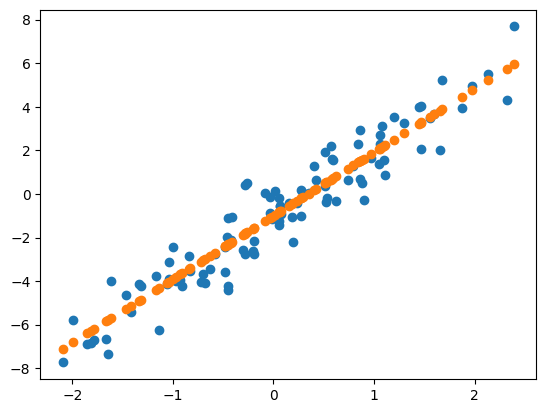

In [61]:
# Random data for testing
seed = 1701
key = jax.random.PRNGKey(seed)
key, x_key, n_key = jax.random.split(key, num=3)
xs = jax.random.normal(x_key, shape=(100,1))
noise = jax.random.normal(n_key, shape=(100,1))
ys = xs * 3 - 1 + noise

# Create dataset
dataset = Dataset(xs, ys)

# Create dataloader
data = DataLoader(dataset, key=key, batch_size=100)

# Create model
#model = Sequential([Linear(1,1)])
model = Sequential([Linear(1,1) ])

# Initialize Model
key, l1_key = jax.random.split(key)
key, params = model.init(key)
print (model)


trainer = Trainer(learning_rate=0.002)
print (params)
params = trainer.fit(params, model, data, max_epochs = 1000, log_epoch=100)
print (params)

print(xs.shape)
plt.scatter(xs, ys)

y_hat = jnp.array(model(params, xs))
print (y_hat.shape)
plt.scatter(xs, y_hat);



In [38]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
)


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# xx = sorted(set(list(y.item())))
labels = sorted(set(list([yy.item() for yy in y])))

print(f'{labels = }')


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [4]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# Define model


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)


Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 500 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [11]:
# 20 epochs on MPS is 1m 18.3s or 3.915s per epoch
# 20 epochs on CPU is 1m 0.8s or 3.04s per epoch
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.605081 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.596671 

Done!


In [38]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")


Saved PyTorch Model State to model.pth


In [39]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

In [25]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    for i, (x, y) in enumerate(test_data):
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: {predicted:>10s},    Actual: {actual:>10s}')
        if i > 10:
            break


Predicted: Ankle boot,    Actual: Ankle boot
Predicted:   Pullover,    Actual:   Pullover
Predicted:    Trouser,    Actual:    Trouser
Predicted:    Trouser,    Actual:    Trouser
Predicted:      Shirt,    Actual:      Shirt
Predicted:    Trouser,    Actual:    Trouser
Predicted:       Coat,    Actual:       Coat
Predicted:       Coat,    Actual:      Shirt
Predicted:    Sneaker,    Actual:     Sandal
Predicted:    Sneaker,    Actual:    Sneaker
Predicted:       Coat,    Actual:       Coat
Predicted:     Sandal,    Actual:     Sandal


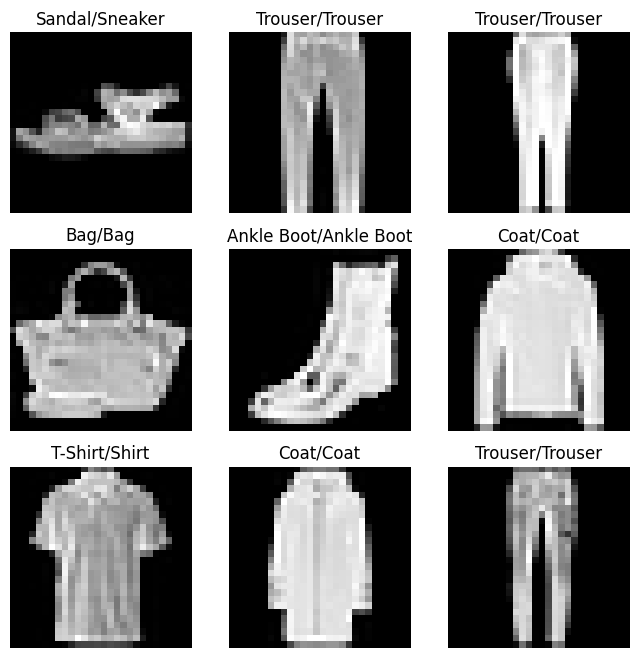

In [37]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    pred = model(img)
    predicted, actual = labels_map[pred[0].argmax(0).item()], labels_map[y]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label] + '/' + predicted)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
